# 4-1. 프로젝트: 뉴스기사 요약해보기
---
새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

먼저 주요 라이브러리 버전을 확인해 보죠.


Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

https://github.com/sunnysai12345/News_Summary
아래의 코드로 데이터를 다운로드할 수 있어요.

이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.



In [197]:
!pip install summa

In [198]:
from importlib.metadata import version
import nltk
import tensorflow as tf
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

3.8.1
2.15.0
1.5.3
1.2.0


In [199]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [200]:
data.sample(10)

,headlines,text
92246,"Pakistani man claims to eat leaves, wood for 2...",Mehmood Butt from Pakistan claims to have been...
82415,"PM Modi to adopt wrestling village, his third ...",Uttar Pradesh Chief Minister Yogi Adityanath o...
7650,"Not trying to replace Alia, Sidharth, Varun: T...","Talking about Alia Bhatt, Sidharth Malhotra an..."
62511,Facebook could help US retaliate against Russi...,Republican Senator Mitch McConnell has said th...
47269,About 5 crore jobs to be created by next year:...,Around five crore employment opportunities wil...
79276,Hulk Hogan locks himself out of his home in un...,Former WWE star Hulk Hogan got locked out of h...
77224,"ISIS, climate change top world threat list: Su...",People across the world consider the terror gr...
12958,Corporate India has to clean up: Sona Mohapatr...,"Singer Sona Mohapatra, while referring to #MeT..."
90333,Shashi Tharoor's tweet on Portuguese-built chu...,Congress leader Shashi Tharoor was criticised ...
88839,"My 'Don't blush, baby' comment now used for ma...","Speaking about his 'Don't blush, baby!' commen..."


위 데이터프레임을 보면 headline 과 text 밖에 열이 없어서 노드에서 진행 되었던 것 처럼 필요가 있는 열만 가져올 필요가 없기 때문에 그대로 진행 하겠다.

### 중복 샘플과 null 값이 있는지 확인하고 제거하겠다.

In [201]:
print('headlines	 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines	 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


데이터프레임의 drop_duplicates()를 사용해 중복 샘플 제거

In [202]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿔준다.
data.drop_duplicates(subset = ['headlines'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98280


In [203]:
# null 값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


더이상 없애줄 널값이 없기 때문에

### 텍스트 정규화와 불용어 제거를 진행하겠다.

사전(dictionary)을 구성해 텍스트 정규화를 진행하겠다.

이 사전은 아래의 링크를 참고해서 만들겠다.

https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [204]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 정규화 준비는 끝냈고, 불용어를 제거해주겠다.

In [205]:
from nltk.corpus import stopwords

In [206]:
# nltk의 stopwords 데이터셋을 다운받아준다.
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [207]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개이다. 이걸 통해 이용해 불용어를 제거하고, 모든 영어 문자는 소문자로 만들겠다. 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리하겠다.

함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이에요. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같습니다. 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했어요.

In [208]:
from bs4 import BeautifulSoup
import re

In [209]:
# 여기에서는 두 열다 불용어 제거를 진행하기 때문에 불용어 제거 함수를 만들어주겠다.
def preprocess_sentence(sentence):
    sentence = sentence.lower()  # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text  # HTML 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호로 닫힌 문자열 제거
    sentence = re.sub('"', '', sentence)  # 쌍따옴표 제거
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # 'm'이 3개 이상이면 2개로 변경

    # 불용어 제거
    tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    return tokens

In [210]:
temp_headlines = 'Sonu Kumari,"02 Aug 2017,Wednesday"'
temp_text = 'The Brihanmumbai Electric Supply and Transport (BEST) is planning to shift its iconic museum from the Anik Bus Depot at Wadala to Byculla zoo.'

print("headlines: ", preprocess_sentence(temp_headlines))
print("text: ", preprocess_sentence(temp_text))

headlines:  sonu kumari aug wednesday
text:  brihanmumbai electric supply transport planning shift iconic museum anik bus depot wadala byculla zoo


결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, <br />과 같은 html 태그가 제거되었다. (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있다.

In [211]:
# 전체 Headlines 데이터에 대한 전처리
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s))

# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_headlines[:5])

<ipython-input-209-aa675224639c>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text  # HTML 태그 제거


headlines 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


In [212]:
# 전체 Text 데이터에 대한 전처리
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

빈(empty) 샘플이 생겼는지 확인하고 비어있는 샘플은 null 값으로 채워준다.

In [213]:
import numpy as np

In [214]:
data['headlines'] = clean_headlines
data['text'] = clean_text

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [215]:
# Null 값을 .isnull().sum() 이용해서 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [216]:
print('전체 샘플 수 :', (len(data)))

전체 샘플 수 : 98280


### 훈련데이터와 테스트데이터 나누기

학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시한다.
샘플 최대 길이를 정해주겠다.  

헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 13
헤드라인의 평균 길이 : 7.128601953601954
텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.0796805046805


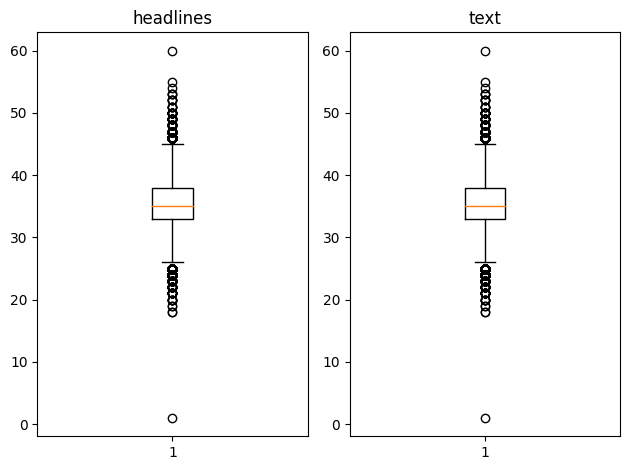

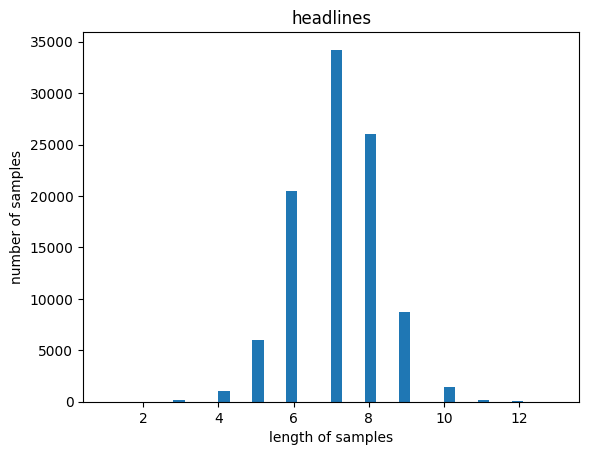

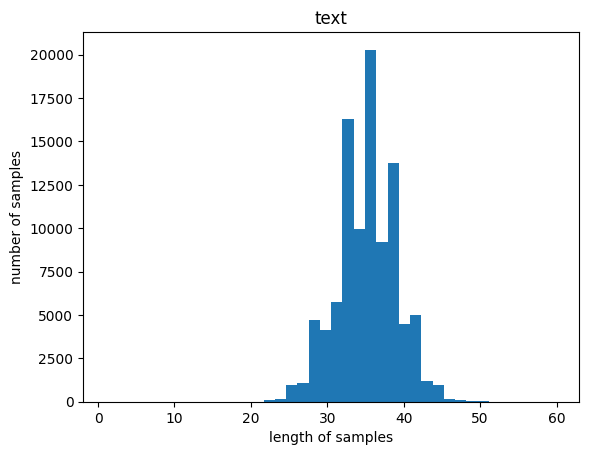

In [217]:
# 길이 분포 출력
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [218]:
# 임의로 적절한 길이 지정
headlines_max_len = 50
text_max_len = 50
print('=3')

=3


In [219]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 판단
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' %(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [220]:
# headlines와 text에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있다.
below_threshold_len(headlines_max_len, data['headlines'])
below_threshold_len(text_max_len,  data['text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998575498575498


In [221]:
# 거의 대부분이 들어오게 잘 설정했지만, text_max_len 길이보다 큰 샘플을 제외하는 코드를 진행하겠다.(headline 은 100% 들어와있기 때문)
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98266


### 시작 토큰과 종료 토큰 추가하기

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있기 때문에, 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가하겠다.
디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 하겠다.

In [222]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

<ipython-input-222-4eb5523174b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
<ipython-input-222-4eb5523174b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')


,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [223]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


훈련 데이터와 테스트 데이터를 분리


In [224]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices) # 배열의 순서를 무작위로 섞어줌
print(indices)

[24938 86486  6793 ... 55169 90698 51317]


In [225]:
# sample Shuffel
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [226]:
# 8:2 비율로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19653


In [227]:
# 테스트 데이터의 개수를 이용해 전체 데이터를 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78613
훈련 레이블의 개수 : 78613
테스트 데이터의 개수 : 19653
테스트 레이블의 개수 : 19653


### 정수 인코딩

단어 집합(vocabulary) 만들기 및 정수 인코딩

In [228]:
from keras.preprocessing.text import Tokenizer

In [229]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다.
또, 단어 집합은 src_tokenizer.word_index에 저장되어있다.

단어 전부를 활용하는 것이 아니라 빈도수가 낮은 단어들은 훈련 데이터에서 제외시키겠다.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인하겠다.

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어있다. 이를 통해 통계를 내겠다.

In [230]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69563
등장 빈도가 6번 이하인 희귀 단어의 수: 47371
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22192
단어 집합에서 희귀 단어의 비율: 68.09798312321205
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4793568193544484


encoder_input_train에는 69582개의 단어가 존재한다.

등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 약 70%를 차지한다.
하지만 실제로 훈련 데이터에서 등장하는 빈도는 3.49% 이다.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼겠다. 훈련데이터에서 제외하고,
위에서 이를 제외한 단어 집합의 크기를 22111개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 22000개로 으로 제한해볼게요. 토크나이저를 정의할 때 num_words의 값을 지정해 제한하겠다.

In [231]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다. 현재 단어 집합의 크기를 22,000으로 제한했으니까 이제 22,000이 넘는 숫자들은 정수 인코딩 후에는 데이터 정제후 사라졌다.

In [232]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[353, 362, 14, 5658, 7263, 86, 241, 5, 2844, 2816, 5157, 63, 87, 5, 4507, 353, 2931, 1332, 8270, 645, 169, 5010, 998, 2903, 452, 353, 8, 2931, 2399, 1868, 259, 870, 17463, 463, 1187], [1227, 80, 5051, 13778, 371, 10, 1533, 130, 5877, 4470, 789, 1274, 5051, 13778, 138, 19433, 4, 4796, 1533, 1006, 789, 3639, 786, 3068, 3152, 138, 5943, 50, 3462, 13779, 6, 371, 30, 1970, 3442, 130, 164, 1228], [198, 1545, 340, 34, 5822, 275, 4797, 471, 3802, 274, 471, 2904, 628, 198, 23, 748, 2486, 101, 416, 51, 471, 1248, 4797, 9306, 11, 1077, 6988, 151, 2303, 2487, 336, 5997, 1779, 2603, 103, 20695, 1192, 13780]]


텍스트 데이터 대신 정수가 나오고 있다.

In [233]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [234]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29932
등장 빈도가 5번 이하인 희귀 단어의 수: 19608
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10324
단어 집합에서 희귀 단어의 비율: 65.50848590137646
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.852796755244405


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지하고 있다. 하지만 빈도 수는 5% 대이기 때문에 크기제한을 10,000으로하겠다.

In [235]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 162, 287, 18, 94, 4, 2985, 99, 597, 4], [1, 3480, 147, 1614, 5796, 1592], [1, 61, 1798, 232, 401, 166, 3069, 212], [1, 2135, 1918, 27, 741, 6379, 1226], [1, 39, 147, 71, 485, 283, 279, 2791]]
target
decoder  [[162, 287, 18, 94, 4, 2985, 99, 597, 4, 2], [3480, 147, 1614, 5796, 1592, 2], [61, 1798, 232, 401, 166, 3069, 212, 2], [2135, 1918, 27, 741, 6379, 1226, 2], [39, 147, 71, 485, 283, 279, 2791, 2]]


정상적으로 정수 인코딩 작업이 끝냈다.
decoder_input_train과 decoder_target_train에는 더 이상 숫자 22,000이 넘는 숫자들은 존재하지 않는다. 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 한다.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아오겠다.
여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않는다.

그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 것이다. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 것이다.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장하겠다. 이 샘플들은 모두 삭제하겠다.

In [236]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78612
훈련 레이블의 개수 : 78612
테스트 데이터의 개수 : 19652
테스트 레이블의 개수 : 19652


삭제하는 훈련 데이터가 많지 않다. :)

훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인 되었다.

### 패딩하기
텍스트 시퀀스를 정수 시퀀스로 변환되었고, 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 진행하겠다. 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰주겠다.

In [237]:
from keras.preprocessing.sequence import pad_sequences

In [238]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=headlines_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=text_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=text_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=text_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=text_max_len, padding='post')
print('=3')

=3


### 모델 설계하기

함수형 API를 이용해서 인코더를 설계하고 LSTM 모델을 이용해 인풋 레이어와 가까운 층에서는

장기기억을 가져가게 학습시키고 인코더의 끝 부분에서는 GRU 모델을 사용해 모델을 가볍게 만들겠다.

| 특징 / 모델 | LSTM | GRU |
|-------------|------|------|
| 게이트의 수 | 3개 (입력 게이트, 출력 게이트, 삭제 게이트) | 2개 (업데이트 게이트, 재설정 게이트) |
| 구조 | 비교적 복잡 | 비교적 간단 |
| 메모리 셀 | 별도의 메모리 셀 존재 | 메모리 셀 없음 |
| 정보 유지 | 장기간의 의존성 정보 유지에 강점 | 중단기간의 의존성 정보 유지에 적합 |
| 계산 비용 | 높음 (더 많은 게이트와 계산 필요) | 낮음 (더 적은 게이트와 계산 필요) |
| 학습 시간 | 상대적으로 긴 학습 시간 | 상대적으로 짧은 학습 시간 |
| 성능 | 복잡한 문제에 적합, 장기 의존성을 잘 처리 | 간단한 문제에 적합, 빠른 학습 및 유사한 성능 제공 가능 |


---
-> 계속 에러떠서...결국

전부 LSTM 으로 다시 다 바꿨다.




In [239]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(headlines_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)  # 이전 레이어의 출력을 입력으로 사용

# 인코더의 LSTM 3
encoder_lstm3= LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)  # 이전 레이어의 출력을 입력으로 사용

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했어요. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터이다.

In [240]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [241]:
from tensorflow.keras.layers import Attention

In [242]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 50, 128)              2816000   ['input_35[0][0]']            
                                                                                                  
 lstm_24 (LSTM)              [(None, 50, 256),            394240    ['embedding_14[0][0]']        
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                           

### 모델 훈련하기

In [243]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 92s 278ms/step - loss: 1.3256 - val_loss: 1.1117
Epoch 2/50
308/308 [==============================] - 84s 274ms/step - loss: 1.1172 - val_loss: 1.1022
Epoch 3/50
308/308 [==============================] - 84s 273ms/step - loss: 1.1128 - val_loss: 1.1024
Epoch 4/50
308/308 [==============================] - 84s 274ms/step - loss: 1.1090 - val_loss: 1.0948
Epoch 5/50
308/308 [==============================] - 84s 273ms/step - loss: 1.1049 - val_loss: 1.0919
Epoch 6/50
308/308 [==============================] - 84s 274ms/step - loss: 1.1012 - val_loss: 1.0985
Epoch 7/50
308/308 [==============================] - 84s 274ms/step - loss: 1.0978 - val_loss: 1.0839
Epoch 8/50
308/308 [==============================] - 84s 274ms/step - loss: 1.0922 - val_loss: 1.0800
Epoch 9/50
308/308 [==============================] - 85s 275ms/step - loss: 1.0834 - val_loss: 1.0706
Epoch 10/50
308/308 [==============================] - 85s 275ms/step - l

In [244]:
# 시각화를 Seaborn 으로 진행
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

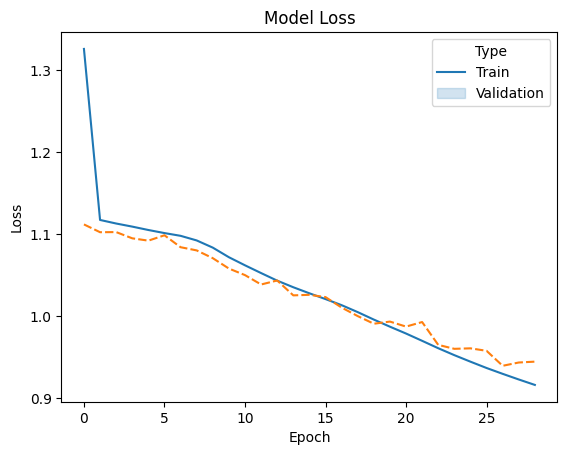

In [245]:
# 학습 데이터를 DataFrame으로 변환
history_df = pd.DataFrame(history.history)

# 손실률 그래프 그리기
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(title='Type', loc='upper right', labels=['Train', 'Validation'])

# 그래프 표시
plt.show()

### 인퍼런스 모델 구현하기

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르다. 그래서 별도로 진행해줘야한다.
훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비하겠다.

정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야한다.
인코더 모델과 디코더 모델을 분리해서 설계하겠다.

In [260]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [261]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층

In [262]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [263]:
encoder_model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_14 (Embedding)    (None, 50, 128)           2816000   
                                                                 
 lstm_24 (LSTM)              [(None, 50, 256),         394240    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
 lstm_25 (LSTM)              [(None, 50, 256),         525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
 lstm_26 (LSTM)              [(None, 50, 256),         525

In [264]:
decoder_model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_36 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_15 (Embedding)    (None, None, 128)            1280000   ['input_36[0][0]']            
                                                                                                  
 input_40 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_41 (InputLayer)       [(None, 256)]                0         []                            
                                                                                           

In [294]:
def decode_sequence(input_seq):
    # 인코더 모델을 통해 인코더 출력과 상태 얻기
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # 초기 디코더 입력 (예: <start> 토큰)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # 다음 토큰 예측
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token != 'eostoken'):
            decoded_sentence += ' ' + sampled_token

        # 종료 조건 체크
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (text_max_len-1)):
            stop_condition = True

        # 타겟 시퀀스 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence


### 모델 테스트하기

In [295]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
sos_index = 1  # 시작 토큰의 인덱스
eos_index = 2  # 종료 토큰의 인덱스

def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0 and i != sos_index and i != eos_index):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


테스트 데이터 약 20개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

In [296]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [297]:
print(input_seq_padded.shape)


(1, 50)


In [298]:
for i in range(50, 100):
    # 입력 시퀀스를 모델의 입력 형태에 맞게 조정
    input_seq = encoder_input_test[i].reshape(1, -1)
    input_seq_padded = pad_sequences(input_seq, maxlen=text_max_len, padding='post')

    # input_seq_padded의 차원 확인
    print("input_seq_padded shape:", input_seq_padded.shape)

    # 원문, 실제 요약, 예측 요약 출력
    print("원문 :", seq2headlines(encoder_input_test[i]))
    print("실제 요약 :", seq2text(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(input_seq_padded))
    print("\n")

input_seq_padded shape: (1, 50)
원문 : world number naomi osaka face serena williams us open final one time grand slam champion first flushing title osaka first japanese woman advance grand slam final osaka serena faced japanese emerging winner 
실제 요약 : serena us open final rival st us open 
1/1 [==============================] - 0s 22ms/step
예측 요약 :  world world world world world time


input_seq_padded shape: (1, 50)
원문 : sadhvi saraswati said killed gau mata organised beef parties kerala right live india hundreds people posted beef facebook page user commented beef kerala relocate kerala users also posted pictures state bjp leaders allegedly consuming beef 
실제 요약 : sadhvi trolled beef gau mata 
1/1 [==============================] - 0s 22ms/step
예측 요약 :  video die protest


input_seq_padded shape: (1, 50)
원문 : delhi police wednesday registered fir businessman repeatedly raping torturing year old maid three months police told girl originally west bengal kept captivity allowed go employ

### summa 로 추출적 요약하기

In [299]:
!pip install summa

In [300]:
!pip list | grep summa

summa                            1.2.0
torchsummary                     1.5.1


In [301]:
import requests
from summa.summarizer import summarize

In [302]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
# 데이터 로드
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

# 예시로 첫 번째 뉴스 기사의 본문을 사용
text = data['text'][0]

# summarize 함수를 사용하여 요약 생성
# ratio는 원본에서 요약문이 차지할 비율을 설정
# words는 요약문의 단어 수를 지정
# ratio와 words 중 하나만 설정
summary = summarize(text, ratio=0.5)

print("원문:", text)
print("\n요약:", summary)


원문: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

요약: upGrad's Online Power Learning has powered 3 lakh+ careers.


# 회고
---

Keep: 계속 시도하는 것! 끝까지 포기 안하는 것!!!

Problem: 중간에 에러가 떠서 왜 문제가 계속 뜨지 하면서 멘붕이 왔었는데, 중간에 변수를 잘못쓴 부분이 있었다.

Try: 다음에도 시도를 계속하겠지만 멘탈을 빨리 부여잡는 노력을 해야겠다!